In [3]:
# libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy
from scipy.integrate import simps as simps
from random import randrange
from datetime import date
from numpy.random import normal
from datetime import datetime
import time
import multiprocessing
from multiprocessing import Pool
from functools import partial
import itertools
from scipy.integrate import quad as integrate
from scipy.integrate import simps as simps
from scipy import interpolate as interp
from scipy.stats import norm
from itertools import product
from scipy.interpolate import interp1d
from tqdm import tqdm


# funs 
def EulerMaruyama_approx_sol(N, mu, sigma, x0):
    """
    Returns discrete numerical approximation of stochastic process solving an SDE of the form
            dX(t) =  b(t)X(t) dt + c(t)dW(t) 
    by approximating the continous solution X(t) by random variables 
    X_n = X(t_n) where t_n = n∆t, n = 0,1,2, and ∆t = 1/N

    Parameters
    ----------
    N : int
        Discretisation of [0,1] interval. Determines step size ∆t = 1/N
    mu : function
        Drift of SDE, takes (x, t) as input
    sigma : function
        Diffusion of SDE, takes (x, t) as input 
    x0 : float
        Starting point of solution

    Returns
    ----------
    X : array(float) np.array of size N
    """ 

    t = np.linspace(0,1,N)
    X = np.zeros(N)
    
    X[0] = x0
    dt = 1/N
    
    for i in range(N-1):
        dX = X[i]*mu(t[i])*dt + sigma(t[i])*normal()*np.sqrt(dt)
        X[i+1] = X[i] + dX
    return X

def generate_sparse_obs__forScores(n, r, dt, mu, sigma, x0, N, sigma_noise ):
    N = int(dt**(-1)) 
    X = []; T = []; Y = []; C = []
    for i in (range(n)):
        X_i = EulerMaruyama_approx_sol(N = N, mu= mu , sigma=sigma, x0 = x0); X.append(X_i)
        T_i = []; Y_i = []
        for j in range(r):
            random_input = randrange(N)
            T_ij = random_input/N
            Y_ij = X_i[random_input] + np.random.normal(scale = sigma_noise)
            Y_i.append(Y_ij); T_i.append(T_ij)
        Y.append(np.array([Y_i[j] for j in np.argsort(T_i)]))  
        T.append(np.array([T_i[j] for j in np.argsort(T_i)]))
    X = np.array(X); T = np.array(T); Y = np.array(Y)
    return T,Y       

def univariate_local_linear_smoothing(T,Y,K,h):
    r = Y.shape[1]; n  = Y.shape[0]; _nr = n*r
    T = T.reshape(-1); Y = Y.reshape(-1)
    K_h = lambda t: K(t/h)/h   
    cali_T = lambda t0 : np.array( [ ( (T - t0) )**p for p in [0,1] ] ).T
    bold_W = lambda t0 : np.diag(np.array([K_h(_t - t0) for _t in T]))
    def minimizers(t0):
        try:
            res =  np.linalg.inv(  cali_T(t0).T @ bold_W(t0) @ cali_T(t0) )  @ cali_T(t0).T @  bold_W(t0) @  Y 
        except:
            res =   np.linalg.pinv(  cali_T(t0).T @ bold_W(t0) @ cali_T(t0) )@ cali_T(t0).T @  bold_W(t0) @  Y 
        return  res
    return lambda t0: minimizers(t0)
          
def bivariate_local_linear_smoothing_triangular(T,Y,K,h, bias = True):
    r = Y.shape[1]; n  = Y.shape[0]
    if bias is True:
        upper_triangular_pairs = set(
            pair for pair in zip(*np.triu_indices(r))).difference(set(zip(np.arange(r),np.arange(r))))
    else:
        upper_triangular_pairs = set(pair for pair in zip(*np.triu_indices(r)))

    utp_T = [(T_i[j], T_i[k]) for (j,k) in upper_triangular_pairs for T_i in T ]
    utp_Y = [(Y_i[j], Y_i[k]) for (j,k) in upper_triangular_pairs for Y_i in Y ]

    Kh = lambda t: K(t/h)/h

    caliK = lambda s,t : np.diag( np.array([ Kh(T_ij-s)*Kh(T_ik-t) for (T_ij, T_ik) in utp_T ]))

    caliY = np.array([ Y_ij*Y_ik for (Y_ij, Y_ik) in utp_Y ]) 

    caliX = lambda s,t : np.array([ np.array([ 1, T_ij - s, T_ik - t ]) for (T_ij, T_ik) in utp_T ]) 
    
    def minimizers(s,t):
        _caliX = caliX(s,t); _caliK = caliK(s,t); _caliY = caliY; XtransposeK =  _caliX.T @ _caliK

        try:
            res = np.linalg.inv(  XtransposeK @ _caliX) @ XtransposeK @ _caliY
        except:
            res = np.linalg.pinv(  XtransposeK @ _caliX) @ XtransposeK @ _caliY
        return  res

    return lambda s,t : minimizers(min(s,t), max(s,t))

def bivariate_local_linear_smoothing_triangular_exp(T,Y,K,h, bias = True):
    
    Kh = lambda t: K(t/h)/h
    def Khp(p):
        return lambda t: (t/h)**p*Kh(t)
    
    if bias is True:
        upper_triangular_pairs = set(
            pair for pair in zip(*np.triu_indices(r))).difference(set(zip(np.arange(r),np.arange(r))))
    else:
        upper_triangular_pairs = set(pair for pair in zip(*np.triu_indices(r)))

   
    def a0_a1_a2(s,t):
        def Ap(p1,p2):
            return lambda s,t : np.array([ Khp(p1)(s - T_i[j])*Khp(p2)(t - T_i[k])
                                    for (j,k) in upper_triangular_pairs for T_i in T ]).sum()
        def Sp(p1,p2):
            return lambda s,t : np.array([ Khp(p1)( s - T_i[ j ] )  *  Khp(p2)( t - T_i[ k ]  )\
                                  *( Y_i[j] * Y_i[ k ] )
                                    for (j,k) in upper_triangular_pairs for T_i,Y_i in zip(T,Y) ]).sum()

        S_00 = Sp(0,0)(s,t)
        S_01 = Sp(0,1)(s,t)
        S_10 = Sp(1,0)(s,t)
        A_00 = Ap(0,0)(s,t)
        A_10 = Ap(1,0)(s,t)
        A_01 = Ap(0,1)(s,t)
        A_11 = Ap(1,1)(s,t)
        A_20 = Ap(2,0)(s,t)
        A_02 = Ap(0,2)(s,t)
        calM_1 =  A_20 * A_02 - A_11**2
        calM_2 =  - A_10 * A_02 + A_01*A_11
        calM_3 =  A_10 * A_11 - A_01*A_20
        determinant = calM_1*A_00 + calM_2*A_10 + calM_3*A_01
        a0 = (calM_1*S_00 + calM_2*S_10 + calM_3*S_01) / determinant
        calM_1 =  - A_10 * A_02 + A_01*A_11
        calM_2 =  A_00 * A_02 - A_01*A_01
        calM_3 =  - A_00 * A_11 + A_01*A_01
        a1 = (calM_1*S_00 + calM_2*S_10 + calM_3*S_01) / determinant
        calM_1 =  A_10 * A_11 - A_01*A_20
        calM_2 =  - A_00 * A_11 + A_01*A_10
        calM_3 =  A_00 * A_20 - A_10*A_01
        a2 = (calM_1*S_00 + calM_2*S_10 + calM_3*S_01) / determinant
        return a0, a1, a2
    return lambda s,t : a0_a1_a2(min(s,t),max(s,t))

def get_mu(m,dm):
    return lambda t : dm(t)*(m(t))**(-1)

def get_sigma2_DIAGONAL_fromFull(_m, _dm, _G, _D1_G, _D2_G, _mu):
    N = _m.size
    time_grid = np.linspace(0,1,N)
    def res(t):
        t_ix = np.argmin((t-time_grid)**2)
        return (np.diagonal(_D1_G + _D2_G) - 2*_m*_dm  - 2*_mu*(np.diagonal(_G) - _m**2))[t_ix]   
    
    return lambda t : res(t)

def get_sigma2_DIAGONAL_fromDiag(_m, _dm, _diag_G, _diag_dG, _mu):
    N = _m.size
    time_grid = np.linspace(0,1,N)
    def res(t):
        t_ix = np.argmin((t-time_grid)**2)
        return (_diag_dG - 2*_m*_dm  - 2*_mu*(_diag_G - _m**2))[t_ix]   

    return lambda t : res(t)

def get_sigma2_TRIANGULAR(_m, _dm, _G, _D1_G, _b):

    N = _m.size
    time_grid = np.linspace(0,1,N)
    def res(s):
#         s_ix = max( 0, np.argmin((s-time_grid)**2)-1)
        s_ix = np.argmin((s- 0.021 -time_grid)**2)
            
        def second(s_ix,t_ix):
            return simps(_b[s_ix : t_ix+1]*_D1_G[s_ix, s_ix : t_ix+1], time_grid[s_ix: t_ix+1]  )
        
        return np.array(
                [ _D1_G[s_ix, t_ix ] - _b[s_ix]*_G[s_ix, s_ix ] - second(s_ix,t_ix)
                  for t_ix in np.arange(s_ix, time_grid.size-1)     ]).mean()

    return lambda s : res(s)


def run_exp(n, r, dt, mu, sigma, x0, N, sigma_noise, it=0):

    time_grid = np.linspace(0,1,N)
    
    T,Y = generate_sparse_obs__forScores(n, r, dt, mu, sigma, x0, N, sigma_noise )
    
    if sigma_noise == 0:
        bias = False
    else:
        bias = True 
        
    # evaluation interval
    eval_start_ix = np.argmin((time_grid -.1)**2); eval_end_ix = np.argmin((time_grid -.9)**2)

    # bandwith
    h_m = 5*(n*r)**(-1/5); h_G = 1.5*(n*r)**(-1/5)
    
    # smoothing kernel
    K = lambda x : 3/4*(1-x**2) if  3/4*(1-x**2) > 0 else 0;      

    # -------------------------------------------- compute -------------------------------------------- #
    ##### m
    _M_ = np.array([univariate_local_linear_smoothing(T, Y, K, h_m)(t) for t in (time_grid)])
    MHAT = _M_[:,0]
    dMHAT = _M_[:,1]

    ##### G
    GHAT, D1GHAT, D2GHAT = np.zeros(shape = (N,N)), np.zeros(shape = (N,N)), np.zeros(shape = (N,N))

    for i,s in (zip(np.arange(N),time_grid)):
        for j,t in zip(np.arange(i,N),time_grid[i:]):
            _G_ =  bivariate_local_linear_smoothing_triangular_exp(T,Y,K,h_G,bias)(s,t)
            GHAT[i,j] = _G_[0];            GHAT[j,i] = _G_[0]
            D1GHAT[i,j] = _G_[1];          D1GHAT[j,i] = _G_[1]
            D2GHAT[i,j] = _G_[2];          D2GHAT[j,i] = _G_[2]
            
    # diag_G_ 
    _diag_G_ = np.array([univariate_local_linear_smoothing(T, Y**2, K, h_G)(t) for t in time_grid])
    diag_GHAT = _diag_G_[:,0]
    diag_dGHAT = _diag_G_[:,1]


    # -------------------------------------------- evaluate -------------------------------------------- #

    MU = np.array([mu(t) for t in time_grid])
    SIGMA = np.array([sigma(t) for t in time_grid])

    # mu -- drift     
    MUHAT = dMHAT/MHAT
    rmse_drift = ((((MU-MUHAT)**2)[eval_start_ix:eval_end_ix]).mean())**.5


    # sigma -- diffusion 
    SIGMASQUAREDHAT_tria = np.array([get_sigma2_TRIANGULAR(
        MHAT, dMHAT, GHAT, D1GHAT, MUHAT)(t) for t in time_grid])
    rmse_tria = ((((SIGMA **2-SIGMASQUAREDHAT_tria)**2)[eval_start_ix:eval_end_ix]).mean())**.5


    if sigma_noise == 0:
        SIGMASQUAREDHAT_diag_D =  np.array([get_sigma2_DIAGONAL_fromDiag(
            MHAT, dMHAT, diag_GHAT, diag_dGHAT, MUHAT)(t) for t in time_grid])
        rmse_diag_D = ((((SIGMA**2-SIGMASQUAREDHAT_diag_D)**2)[eval_start_ix:eval_end_ix]).mean())**.5
    else:
        rmse_diag_D = np.nan
        SIGMASQUAREDHAT_diag_D = np.nan

    SIGMASQUAREDHAT_diag_T =  np.array([get_sigma2_DIAGONAL_fromFull(
        MHAT, dMHAT, GHAT, D1GHAT, D2GHAT, MUHAT)(t) for t in time_grid])
    rmse_diag_T = ((((SIGMA**2-SIGMASQUAREDHAT_diag_T)**2)[eval_start_ix:eval_end_ix]).mean())**.5
    
    return rmse_drift,rmse_tria,rmse_diag_D,rmse_diag_T, MUHAT, SIGMASQUAREDHAT_tria,SIGMASQUAREDHAT_diag_D, SIGMASQUAREDHAT_diag_T



----

In [18]:
x0 =1


mu = lambda t : - (1)/(1-t)
sigma = lambda t : 1

# mu = lambda t : -2
# sigma = lambda t : np.sin(np.pi*t)

# mu = lambda t : - (1)/(1+t)
# sigma = lambda t : (1)/(1+t)



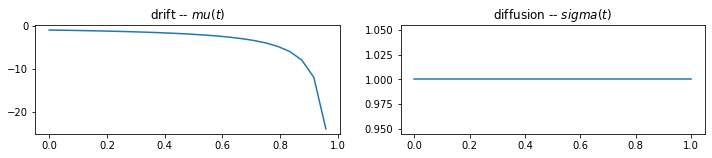

In [19]:
# in
n = 500
r = 5
sigma_noise = 0




N = 25;   
dt = 1e-3

np.seterr(divide='ignore')
time_grid = np.linspace(0,1,N)
fig, [axL,axR] = plt.subplots(figsize = (12,2), ncols = 2)
axL.plot(time_grid, [mu(t) for t in time_grid])
axL.set_title('drift -- $mu(t)$')
axR.plot(time_grid, [sigma(t) for t in time_grid])
axR.set_title('diffusion -- $sigma(t)$')
plt.show()


----

In [20]:
def run(n, r, dt, mu, sigma, x0, N, sigma_noise, it=0):

    time_grid = np.linspace(0,1,N)
    
    T,Y = generate_sparse_obs__forScores(n, r, dt, mu, sigma, x0, N, sigma_noise )
    
    if sigma_noise == 0:
        bias = False
    else:
        bias = True 
        
    # evaluation interval
    eval_start_ix = np.argmin((time_grid -.1)**2); eval_end_ix = np.argmin((time_grid -.9)**2)

    

    
    # smoothing kernel
    K = lambda x : 3/4*(1-x**2) if  3/4*(1-x**2) > 0 else 0;      

    # -------------------------------------------- compute -------------------------------------------- #
    
    h_m = 1.5*(n*r)**(-1/5);
    h_G = 1.5*(n*r)**(-1/5)
#     h_m = 5*(n*r)**(-1/5); h_G = 5*(n*r)**(-1/5)
    
    ##### m
    _M_ = np.array([univariate_local_linear_smoothing(T, Y, K, h_m)(t) for t in (time_grid)])
    MHAT = _M_[:,0]
    dMHAT = _M_[:,1]

    ##### G

    if r<11:
        GHAT, D1GHAT, D2GHAT = np.zeros(shape = (N,N)), np.zeros(shape = (N,N)), np.zeros(shape = (N,N))
        for i,s in tqdm(zip(np.arange(N),time_grid), total =N):
            for j,t in zip(np.arange(i,N),time_grid[i:]):
                _G_ =  bivariate_local_linear_smoothing_triangular(T,Y,K,h_G,bias)(s,t).reshape(-1)
                GHAT[i,j] = _G_[0];            GHAT[j,i] = _G_[0]
                D1GHAT[i,j] = _G_[1];          D1GHAT[j,i] = _G_[1]
                D2GHAT[i,j] = _G_[2];          D2GHAT[j,i] = _G_[2]

    else:
        _GHAT, _D1GHAT, _D2GHAT = [],[],[]
        for T_i, Y_i in tqdm(zip(T,Y), total = n):
            T_i = T_i.reshape(1,-1); Y_i = Y_i.reshape(1,-1)
            GHAT_i, D1GHAT_i, D2GHAT_i = np.zeros(shape = (N,N)), np.zeros(shape = (N,N)), np.zeros(shape = (N,N))
            for i,s in zip(np.arange(N),time_grid):
                for j,t in zip(np.arange(i,N),time_grid[i:]):
                    _G_ =  bivariate_local_linear_smoothing_triangular(T_i,Y_i,K,h_G,bias)(s,t).reshape(-1)
                    GHAT_i[i,j] = _G_[0]; GHAT_i[j,i] = _G_[0]
                    D1GHAT_i[i,j] = _G_[1]; D1GHAT_i[j,i] = _G_[1]
                    D2GHAT_i[i,j] = _G_[2]; D2GHAT_i[j,i] = _G_[2]
                _GHAT.append(GHAT_i); _D1GHAT.append(D1GHAT_i); _D2GHAT.append(D2GHAT_i)   

        GHAT, D1GHAT, D2GHAT = np.zeros(shape = (N,N)), np.zeros(shape = (N,N)), np.zeros(shape = (N,N))
        Kh = lambda t: K(t/h_m)/h_m
        for i,t_i in enumerate(time_grid):
            weights_t_i = [np.array([Kh(t_i-tt) for tt in T[k]]) for k in range(n)]
            for j,t_j in enumerate(time_grid):
                weights_t_j = [np.array([Kh(t_j-tt) for tt in T[k]]) for k in range(n)]
                weights = []
                for k in range(n):
                    weight_k = sum(weights_t_j[k]*weights_t_i[k])
                    weights.append(weight_k)
                if sum(weights)==0:
                    print('aha!')
                GHAT[i,j] = 1/(sum(weights)) * sum([weights[k] * _GHAT[k][i,j] for k in range(n)])
                D1GHAT[i,j] = 1/(sum(weights)) * sum([weights[k] * _D1GHAT[k][i,j] for k in range(n)])
                D2GHAT[i,j] = 1/(sum(weights)) * sum([weights[k] * _D2GHAT[k][i,j] for k in range(n)])

    GDIAGHAT = np.diagonal(GHAT)
    D1GDIAGHAT = np.diagonal(D1GHAT)
    D2GDIAGHAT = np.diagonal(D2GHAT)

    dGDIAGHAT = np.diagonal(D1GHAT + D2GHAT)
    GDIAGHAT = np.diagonal(GHAT)


    # diag_G_ 
    _diag_G_ = np.array([univariate_local_linear_smoothing(T, Y**2, K, h_G)(t) for t in time_grid])
    diag_GHAT = _diag_G_[:,0]
    diag_dGHAT = _diag_G_[:,1]


    # -------------------------------------------- evaluate -------------------------------------------- #

    MU = np.array([mu(t) for t in time_grid])
    SIGMA = np.array([sigma(t) for t in time_grid])
                      
    # mu -- drift     
    MUHAT = dMHAT/MHAT
    rmse_drift = ((((MU-MUHAT)**2)[eval_start_ix:eval_end_ix]).mean())**.5


    # sigma -- diffusion 
    SIGMASQUAREDHAT_tria = np.array([get_sigma2_TRIANGULAR(
        MHAT, dMHAT, GHAT, D1GHAT, MUHAT)(t) for t in time_grid])
    rmse_tria = ((((SIGMA **2-SIGMASQUAREDHAT_tria)**2)[eval_start_ix:eval_end_ix]).mean())**.5


    if sigma_noise == 0:
        SIGMASQUAREDHAT_diag_D =  np.array([get_sigma2_DIAGONAL_fromDiag(
            MHAT, dMHAT, diag_GHAT, diag_dGHAT, MUHAT)(t) for t in time_grid])
        rmse_diag_D = ((((SIGMA**2-SIGMASQUAREDHAT_diag_D)**2)[eval_start_ix:eval_end_ix]).mean())**.5
    else:
        rmse_diag_D = np.nan
        SIGMASQUAREDHAT_diag_D = np.nan

    SIGMASQUAREDHAT_diag_T =  np.array([get_sigma2_DIAGONAL_fromFull(
        MHAT, dMHAT, GHAT, D1GHAT, D2GHAT, MUHAT)(t) for t in time_grid])
    rmse_diag_T = ((((SIGMA**2-SIGMASQUAREDHAT_diag_T)**2)[eval_start_ix:eval_end_ix]).mean())**.5
    
    return rmse_drift,rmse_tria,rmse_diag_D,rmse_diag_T, MUHAT, SIGMASQUAREDHAT_tria,SIGMASQUAREDHAT_diag_D, SIGMASQUAREDHAT_diag_T

In [21]:
MU = np.array([mu(t) for t in time_grid])
SIGMA = np.array([sigma(t) for t in time_grid])


In [22]:
start = datetime.now()
rmse_drift,rmse_tria,rmse_diag_D,rmse_diag_T, MUHAT, SIGMASQUAREDHAT_tria,SIGMASQUAREDHAT_diag_D \
     , SIGMASQUAREDHAT_diag_T  = run(n, r, dt, mu, sigma, x0, N, sigma_noise, it=0)
end = datetime.now()
print(end-start)


100%|██████████| 25/25 [00:45<00:00,  1.83s/it]


0:00:49.445596


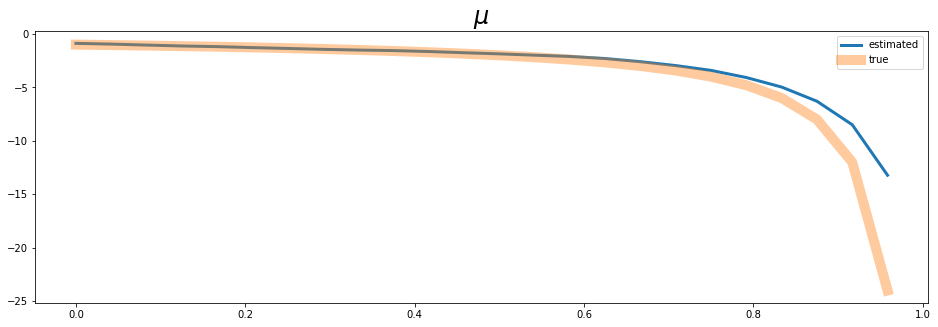

RMSE:               0.93


In [23]:
# mu -- DRIFT 

MU = np.array([mu(t) for t in time_grid])
# fig, [[axUL,axUR],[axDL,axDR]]  = plt.subplots(figsize=(16,5),nrows=2,ncols=2)

fig,ax  = plt.subplots(figsize=(16,5))

# fig.suptitle('$C^2$', fontsize=24)
ax.set_title('$\mu$', fontsize=24)
ax.plot(time_grid[:-1], MUHAT[:-1], label ='estimated', lw=3)
ax.plot(time_grid[:-1],( MU)[:-1], label ='true', lw=10, alpha=0.4)
ax.legend()
# ax.set_ylim(0,2)
plt.show()

print('RMSE:               {:.2f}'.format(np.abs(MUHAT - MU)[:-1].mean()**.5))


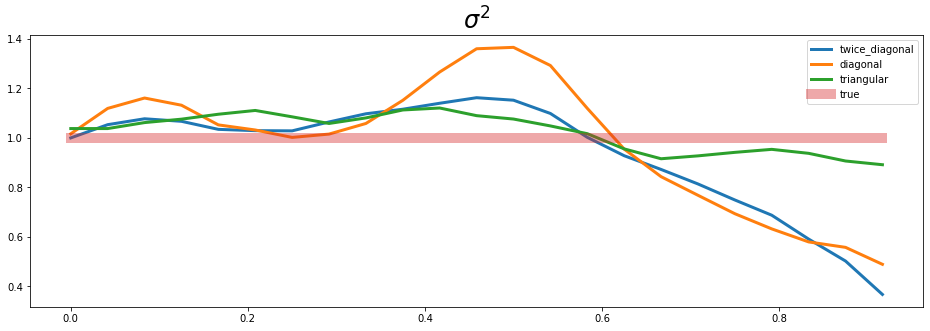

RMSE twice_diagonal:           0.40
RMSE diagonal:                 0.45
RMSE triangular:               0.27


In [25]:
# sigma -- DIFFUSION 

SIGMA = np.array([sigma(t) for t in time_grid])

fig,ax  = plt.subplots(figsize=(16,5))

# fig.suptitle('$C^2$', fontsize=24)
ax.set_title('$\sigma^2$', fontsize=24)
ax.plot(time_grid[:-2], SIGMASQUAREDHAT_diag_D[:-2], label ='twice_diagonal', lw=3)
ax.plot(time_grid[:-2], SIGMASQUAREDHAT_diag_T[:-2], label ='diagonal', lw=3)
ax.plot(time_grid[:-2],  SIGMASQUAREDHAT_tria[:-2], label ='triangular' , lw=3)

# ax.plot(time_grid[:-2],  CHECK[:-2], label ='CHECK' , lw=3)

# ax.set_xlim(.15,.85)

ax.plot(time_grid[:-2],( SIGMA**2)[:-2], label ='true', lw=10, alpha=0.4)
ax.legend()
# ax.set_ylim(0,2)
plt.show()

print('RMSE twice_diagonal:           {:.2f}'.format(np.abs(SIGMASQUAREDHAT_diag_D - SIGMA**2)[:-2].mean()**.5))
print('RMSE diagonal:                 {:.2f}'.format(np.abs(SIGMASQUAREDHAT_diag_T - SIGMA**2)[:-2].mean()**.5))
print('RMSE triangular:               {:.2f}'.format(np.abs(SIGMASQUAREDHAT_tria - SIGMA**2)[:-2].mean()**.5))
# print('CHECK:               {:.2f}'.format(np.abs(CHECK - SIGMA**2).mean()**.5))



---

---

---

---

In [ ]:
# CHECK
# m = lambda t : x0*(1-t)
# dm =  lambda t : -x0
# G_diag = lambda t : t-t*2 - m(t)*2
# dG_diag =  lambda t : 1-2*t - 2*m(t)*dm(t)
# G = lambda s,t : min(s,t) - s*t + m(t)*m(s)
# D1_G = lambda s,t : 1-max(s,t) + m(t)*dm(s)
# D2_G = lambda s,t : - min(s,t) + m(s)*dm(t)


# _M =  np.array([m(t) for t in time_grid])
# _dM =  np.array([dm(t) for t in time_grid])

# GDIAG = np.array([G(t,t) for t in time_grid]).reshape(-1)
# dGDIAG = np.array([dG_diag(t) for t in time_grid]).reshape(-1) 
# D1GDIAG = np.array([D1_G(t,t) for t in time_grid]).reshape(-1)
# D2GDIAG = np.array([D2_G(t,t) for t in time_grid]).reshape(-1)

# _G, _D1_G, __ = np.zeros(shape = (N,N)), np.zeros(shape = (N,N)), np.zeros(shape = (N,N))
# for i,s in (zip(np.arange(N),time_grid)):
#     for j,t in zip(np.arange(i,N),time_grid[i:]):
#         _G[i,j] = G(s,t);           _G[j,i] = G(s,t)
#         _D1_G[i,j] = D1_G(s,t);     _D1_G[j,i] = D1_G(s,t)

                
                

# check = get_sigma2_TRIANGULAR(_M, _dM, _G, _D1_G, MU)
# CHECK = np.array([check(t) for t in time_grid])